# Monte Carlo Sampling and MCMC


## Rejection Sampling


taken from [https://www.deep-teaching.org/notebooks/monte-carlo-simulation/sampling/exercise-sampling-rejection]

Rejection sampling is a simple and straightforward algorihtm to generate samples for distributions, which a hard or impossible to sample from, using a second enclosing distribution. Using the enclosing function we will sample points and accept them as sample points for our desired distribution if they lie under the desired distribution curve and otherwise reject them. 



In [286]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

%matplotlib inline


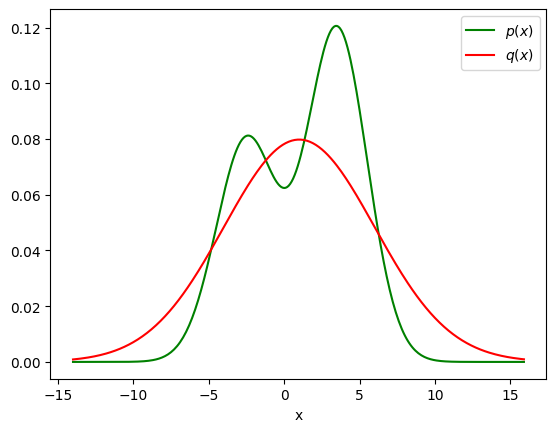

In [287]:
size=40
sigma_square_1 = 4.0
sigma_square_2 = 4.0
mu_1, sigma_1 = -2.5,np.sqrt(sigma_square_1)
mu_2, sigma_2 = 3.5,np.sqrt(sigma_square_1)
prob_1 = 0.4

rv_1 = norm(loc = mu_1, scale = sigma_1)
rv_2 = norm(loc = mu_2, scale = sigma_2)
x_ = np.arange(-14, 16, .1)

p_green = lambda x: prob_1 * rv_1.pdf(x) + (1-prob_1) * rv_2.pdf(x)
plt.plot(x_, p_green(x_) , "g-",label='$p(x)$')

sigma_red,mu_red = 5. , 1.
q_red = lambda x: norm(loc = mu_red, scale = sigma_red).pdf(x)

plt.plot(x_, q_red(x_) , "r-",label='$q(x)$')
plt.legend()

_ = plt.xlabel("x")

We want to sample from the green distribution $p$ above but unfortunately we have no way to do so. We will use the normal distribution $q$ to obtain a sample from $p$ using rejection sampling.

### Exercise

- Implement rejection sampling to get a sample from $p(x)$. 


Let's first hypothesize that we identified a value $M$ such that:
$
\forall x \in \mathbb{R}, p(x) < M\cdot q(x)
$

The algorithm for rejection sampling works as follow:

- Sample a value $x$ from $q$
- Draw an value $u$ using an uniform distribution $\mathcal{U}(0,1)$ and compare $u$ to $\frac{p(x) }{M\cdot q(x)}$
   - if $u < \frac{p(x) }{M\cdot q(x)}$ then accept the sample $x$
   - if $u \geq \frac{p(x) }{M\cdot q(x)}$ discard the sample.


You can use an histogram to verify that your sample is indeed approaching the $p$ distribution.



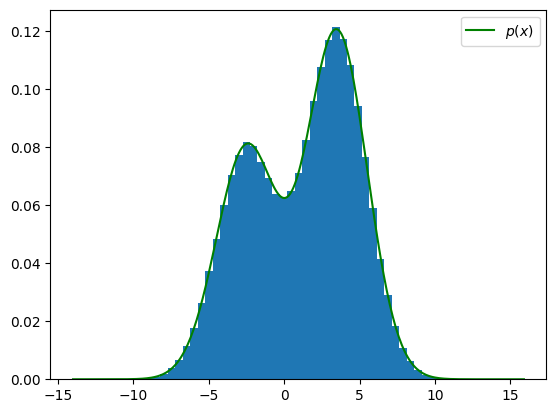

In [288]:
## Your code can go here.

M = 2
samps = 10**6

x = np.random.normal(mu_red, sigma_red, samps)
u = np.random.uniform(0, 1, samps)
mask = u < (p_green(x) / M / q_red(x))
accepted = x[mask]

plt.hist(accepted, bins=50, density=True)
plt.plot(x_, p_green(x_) , "g-",label='$p(x)$')
plt.legend()
plt.show()

# Text decoding using Metropolis-Hasting

In this exercise, we will apply the Metropolis-Hastings algorith, to the problem of decoding encoded by substitution, assuming we known the language of the text. 

We assume also that we can model this language using bigrams (an order 1 Markov chain on the letters). More formally, this language is written over the alphabet $\Lambda$. For example, in English, $\Lambda$ contains upper and lower case letters, punctuation marks, numbers, etc... 

The bigram model is given by $\mu$ and $A$:
 - $\mu$ is the stationary distribution of single letters probabilities
 - $A$ is the transition matrix between letters: it gives for each letter the probability of the next letter. 
 
This model can easily be estimated from a large corpus of text. An encoding (or decoding) function by substitution is a bijective function $\tau: \Lambda \rightarrow \Lambda$. 
If $T′$ is a text, the encoded text $T = \tau(T′)$ is obtained by replacing each letter $c$ of $T′$ by $\tau(c)$.

Our formal problem is thus: given and encoded text $T = (c_1, c_2, . . . . , c_{|T|})$ ($c_i \in \Lambda, \forall i$), retrieve the initial decoded text.

## Preliminaries


1. How do you compute the likelihood of a sequence $T = (c_1, c_2, \cdots, c_{|T|})$ using a bigram model of parameter $(\mu, A)$? 

We note the likelihood this way: 
$
L(T, \mu, A) = P(c_1, c_2, \ldots, c_{|T|}\mid \mu, A) 
$

One way to find the code would be to use simple Monte Carlo and sample encoding functions, using a distribution proportional to the likelihood of the decoded text.

In [289]:
# The probability of a sequence is calculated as in a normal markov chain model:
# P(c1,c2,...,ct) = P(c1) * P(c2|c1) * ... * P(ct|ct-1) = mu(c1) * A(c1,c2) * ... * A(ct-1, ct)

2. How many encoding functions are there? Is it possible to sample?

As the encoding function is bijective on $\Lambda$, there are $|\Lambda|!$ such functions. Sampling seems impossible.

As we cannot sample directly a encoding function we will use MCMC. This method only needs the to know sampling probabilities up to a factor, which is the case here.

We will thus construct a Markov chain on the space of all decoded text, by sampling decoding functions $\tau$. 
The Metropolis-Hastings method works as follow:
- Choose an initial state $\tau_0$ arbitrarily
- Repeat $N$ times the following steps:
    - Compute $\tau$ from $\tau_t$ by swapping exactly 2 letters $c_1$ and $c_2$ in the encoding (see below for details on the function) 
    - Accept the transition from $\tau_t$ to $\tau$ with the probability $\alpha(\tau_t, \tau)$ :
    $$
    \alpha(\tau_t, \tau) = \min \left( 1, \frac{L(\tau(T), \mu, A)\cdot M(\tau_t,\tau)} 
    {L(\tau_t(T), \mu, A)\cdot M(\tau,\tau_t)}\right)
    $$
This mean that ones draw $u \sim \mathcal{U}(0,1)$:
        - if $u < \alpha(\tau_t, \tau)$ then $\tau_{t+1} = \tau$
        - otherwise $\tau_{t+1} = \tau_{t}$


After a sufficient large number of of iterations, the decoding function is drawn according to the probabilities of the decoded text.

3. Show that the log probability of acceptation can be written as:
$$
\log \alpha(\tau_t, \tau) = \min( 0, \log (\mu(\tau(c_1))) + \sum_{i=1}^{|T|} \log ( A(\tau(c_{i}), \tau(c_{i+1})) +  \log(\mu(\tau_t(c_1))) - \sum_{i=1}^{|T|} \log ( A(\tau_t(c_{i}), \tau_t(c_{i+1})))
$$


A3    
We reform as follows
$$
    \log \alpha(\tau_t, \tau) 
    \\
    = \log \min \left(1, \frac{L(\tau(T), \mu, A)} {L(\tau_t(T), \mu, A) } \cdot \frac{M(\tau_t,\tau)}{M(\tau,\tau_t)}\right)
    \\
    = \min \left(0, \log \frac{L(\tau(T), \mu, A)} {L(\tau_t(T), \mu, A)} + \log \frac{M(\tau_t,\tau)}{M(\tau,\tau_t)}\right)
    \\
    = \min \left(0,  \log L(\tau(T), \mu, A)- \log L(\tau_t(T), \mu, A) + \log M(\tau_t,\tau)  - \log M(\tau,\tau_t) \right)
    \\
    = \min \left(0,  \log (\prod_{i=1}^{|T|}A(\tau(c_i), \tau(c_{i+1}))) - \log (\prod_{i=1}^{|T|}A(\tau_t(c_i), \tau_t(c_{i+1}))) + \log M(\tau_t,\tau) - \log M(\tau,\tau_t) \right)
    \\
    = \min \left(0,   (\sum_{i=1}^{|T|}\log A(\tau(c_i), \tau(c_{i+1}))) -  (\sum_{i=1}^{|T|}\log A(\tau_t(c_i), \tau_t(c_{i+1}))) + \log M(\tau_t,\tau) - \log M(\tau,\tau_t) \right)
$$
We know that 
$$
    M = \frac{M(\tau,\tau_t)}{M(\tau_t,\tau)}
$$
and therefore
$$
    L(\tau_t(T), \mu, A) < L(\tau(T), \mu, A) \cdot \frac{M(\tau,\tau_t)}{M(\tau_t,\tau)}
$$
Which holds for
$$
    M(\tau,\tau_t) = \log(\mu(\tau_t(c_1))), M(\tau_t,\tau) = \log(\mu(\tau(c_1)))
$$
And hence
$$
    \log \alpha(\tau_t, \tau) = \min \left(0,   (\sum_{i=1}^{|T|}\log A(\tau(c_i), \tau(c_{i+1}))) -  (\sum_{i=1}^{|T|}\log A(\tau_t(c_i), \tau_t(c_{i+1}))) + \log(\mu(\tau(c_1))) - \log(\mu(\tau_t(c_1))) \right)
$$
Not sure why one of the my subterms is negative rather than positive - maybe a typo?



## Project

1) Download the file `countWar.pkl` which contains the template of bigrams learned from Tolstoy's novel _War and Peace_. This text was chosen because it contains more than 3 million characters, which is long enough to learn a representative model of a language. Also download the `secret.txt` message to decode (or this one `secret2.txt`, same message coded differently in case you would have problems with the first file).

2) Execute the following code to load in python the bigram model and the secret message.

   - The variable `count` is a dictionary: for each letter of the novel _War and Peace_, it provides its number of occurrences in the novel.
   - The pattern of bigrams is described by the variables `mu` and `A`.
   - The variable `mu` is a vector that contains the initial probability distribution over the letters.
   - `A` is a matrix that gives the probabilities of a letter given another letter.
   - `secret` is a variable containing the message to be decoded. 

In [290]:
import pickle as pkl

# Open the dictionary
with open("./countWar.pkl", 'rb') as f:
    (count, mu, A) = pkl.load(f, encoding='latin1')

with open("./secret.txt", 'r') as f:
    secret = f.read()[0:-1] # -1 to suppress the line break
    
with open("./secret2.txt", 'r') as f:
    secret2 = f.read()[0:-1] # -1 to suppress the line break

3) The decoding functions will be represented as a dictionary where the key and the stored value are both of type character (one letter is encoded/decoded into another letter). 
  
Write a function 
  ``` swapF : (char,char) dict -> (char,char) dict ``` <br>
which takes as argument a decoding function $\tau_t$ and returns a new decoding function $\tau$ constructed by swapping two letters $c_1$ and $c_2$ as described in the previous question:
 -  $\tau(c)=\tau_t(c)$ for any $c$ such as $c \ne c_1$ and $c \ne c_2$;
 -  $\tau(c_1)=\tau_t(c_2)$
 -  $\tau(c_2)=\tau_t(c_1)$. 


You can test your function with the following dictionary:

In [291]:
import random
import copy

def swapF(taut: dict[str, str], c1: str = None, c2: str = None) -> dict[str, str]:
    if c1 == None: c1 = random.choice(list(taut.keys()))
    if c2 == None: c2 = random.choice(list(taut.keys()))
    tau = copy.deepcopy(taut)
    tau[c1] = taut[c2]
    tau[c2] = taut[c1]
    return tau

In [292]:
tau = {'a' : 'b', 'b' : 'c', 'c' : 'a', 'd' : 'd' }
print(tau, "\n", swapF(tau))

{'a': 'b', 'b': 'c', 'c': 'a', 'd': 'd'} 
 {'a': 'b', 'b': 'c', 'c': 'd', 'd': 'a'}


4) Write a function `decrypt: string x (char,char) dict -> string` <br>
which, given a `mess` string and a decoding function `tau`, returns the string obtained by decoding `mess` by `tau`.

You can test your function with the following code:

In [293]:
def decrypt(mess: str, tau: dict[str, str]) -> str:
    return "".join([tau[c] for c in list(mess)])

In [294]:
tau = {'a' : 'b', 'b' : 'c', 'c' : 'a', 'd' : 'd' }
print(decrypt("aabcd", tau))
print(decrypt( "dcba", tau))

bbcad
dacb


which will produce the following output:

```
>>> decrypt ("aabcd", tau )
 bbcad
>>> decrypt ("dcba", tau )
 dacb
```

5) Create a dictionary (a hash table) associating to each character its index in `mu` or `A`. The code is simply the following:

In [295]:
chars2index = dict(zip(list(count.keys()), range(len(count.keys()))))

`chars2index['a']` simply gives access to the index corresponding to the letter `a` in `mu` or `A`

If you prefer, you can also use the index file that has already been generated: `fileHash.pkl`

6) Write a function `logLikelihood: string x float np.array x float np.2D-array x (char,int) dict-> string` which, given a `mess` message (string), the arrays `mu` and `A` created in question 2 from `pickle` and the previous dictionary `chars2index`, returns the log-likelihood of the `mess` message with respect to the big diagram model `(mu, A)`.

You can test your function with the following code:

In [296]:
def logLikelihood(mess: str, mu: np.ndarray[float], A: np.ndarray[float], c2i: dict[str, int]) -> float:
    ids = np.vectorize(lambda s: c2i[s])(list(mess))
    return np.log(mu[ids[0]]) + np.sum(np.log(np.vectorize(lambda i: A[ids[i], ids[i+1]])(range(len(ids)-1))))

print(logLikelihood("abcd", mu, A, chars2index), -24.600258560804818)
print(logLikelihood("dcba", mu, A, chars2index), -26.274828997400395)

-24.600258560804814 -24.600258560804818
-26.274828997400398 -26.274828997400395


logLikelihood( "abcd", mu, A, chars2index )
logLikelihood( "dcba", mu, A, chars2index )

which will produce the following output:
```
 >>> logLikelihood( "abcd", mu, A, chars2index )
 -24.600258560804818
 >>> logLikelihood( "dcba", mu, A, chars2index )
 -26.274828997400395
```

7) Code the Metropolis-Hastings method seen in TD as a function called `MetropolisHastings(mess, mu, A, tau, N, chars2index)` using the `swapF`, `decrypt` and `logLikelihood` functions:
  - The `mess` parameter is the coded message.
  - Parameters `mu` and `A` represent the bigram model.
  - The argument `tau` is the initial decoding function to start the Metropolis-Hastings algorithm.
  - The argument `N` is the maximum number of iterations of the algorithm.
  - The argument `chars2index` has already been seen. 

The method is a simple loop where we do the following steps:
  - draw a new decoding function `tau'` by applying swapF with the current decoding function tau as parameter
  - calculation of the log-likelihood of the decoded message thanks to `tau'`.
  - draw to accept or not to accept the transition to `tau'` given the the ratio of likelihoods
  - if the transition is accepted, save the decoded message with the highest likelihood. 

The function returns the most likely decoded message. You will display the log-likelihood each time it is improved and the decoded message is saved.

the function returns the most likely decoded message. You will display the log-likelihood each time it is improved and the corresponding decoded message so that you can observe the evolution of the algorithm.

In order to test your function, you can execute the following code:

In [297]:
def MetropolisHastings(mess: str, mu: np.ndarray[float], A: np.ndarray[float], tau: dict[str, str], N: int, c2i: dict[str, int]) -> str:
    decode = decrypt(mess, tau)
    loglike = logLikelihood(decode, mu, A, c2i)
    best_msg = decode
    best_loglike = loglike
    for i in range(N):
        tau_t = swapF(tau)
        decode_t = decrypt(mess, tau_t)
        loglike_t = logLikelihood(decode_t, mu, A, c2i)
        if np.log(np.random.rand()) < (loglike_t - loglike):
            if loglike_t > loglike:
                best_msg, best_loglike = decode_t, loglike_t
                print(f"Iteration {i}, loglikelihood {loglike:.4f} to {loglike_t:.4f}, message is now {best_msg}")
            tau, decode, loglike = tau_t, decode_t, loglike_t
    return best_msg

In [298]:
def identityTau (count):
    tau = {}
    for k in list(count.keys()):
        tau[k] = k
    return tau

In [299]:
MetropolisHastings(secret2, mu, A, identityTau(count), 10000, chars2index)

Iteration 2, loglikelihood -9339.4354 to -9267.3312, message is now ,""TSK0)ET:92(E9(:TS)v(Tgm)v("(3T)"VEXTgS)gTh)gSqT,mm2v2EXT)gT2EB2E2g(:20)":=T0)gS(0)g29:=TgS(T0V:gT(M)9gTVBT:92(E9(:=T)D)E3VE:TgS(ThmV9(::TVBT)E)"x:2:T)E3T(Eg(m:TVETgS(TE(aThmV9(::TVBTgS(T2Eg(Xm)g2VETVBTKEPEVaE=T2EB2E2g("xT:0)""=TdK)Eg2g2(:qT,D)E3VE2EXTgS(T9VE9(hg2VETVBT9)K:(=T0)gS(0)g29:T:((P:T")a=TgS)gT2:=TgS(ThmVh(mgxT9V00VETgVT)""TKEPEVaE=T2EB2E2g("xT:0)""=T("(0(Eg:qT ET)EVgS(mTBVm0TDKgT)"VEXTgS(T:)0(Th)gSTVBTm(B"(9g2VETgS(TVgS(mT:92(E9(:TS)v(ThmV9((3(3qTCS(ETR(agVET(EKE92)g(3TgS(T")aTVBTXm)v2gxTS(T323TEVgT:)xTgS)gTgS(T:KETVmTgS(T()mgSTS)3T)ThmVh(mgxTVBT)ggm)9g2VE?TS(T:)23TgS)gT)""TDV32(:TBmV0TgS(T")mX(:gTgVTgS(T:0)""(:gTS)v(TgS(ThmVh(mgxTVBT)ggm)9g2EXTVE(T)EVgS(m=TgS)gT2:=T"()v2EXT):23(TgS(TdK(:g2VETVBTgS(T9)K:(TVBTgS(T0Vv(0(EgTVBTgS(TDV32(:=TS(T(Mhm(::(3TgS(ThmVh(mgxT9V00VETgVT)""TDV32(:TBmV0TgS(T2EB2E2g("xT")mX(TgVTgS(T2EB2E2g("xT:0)""qTJS(T:)0(T2:T3VE(TDxTgS(TE)gKm)"T:92(E9(:7T"()v2EXT):23(TgS(TdK(:g2VETVBT9)K

'E6674Z81579X/05X09741J07231J060Q716*5:724127(124V7E33/J/5:7127/5=/5/209/8169U781240812/X9U724078*9270 1X27*=79X/05X09U71L15Q*5972407(3*X0997*=71516)9/9715Q70520397*57240750G7(3*X0997*=72407/520:312/*57*=7Z5;5*G5U7/5=/5/206)798166U7YZ152/2/09V7EL15Q*5/5:72407X*5X0(2/*57*=7X1Z90U781240812/X97900;9761GU724127/9U72407(3*(032)7X*88*572*71667Z5;5*G5U7/5=/5/206)798166U706080529V7K5715*24037=*387LZ2716*5:7240791807(1247*=730=60X2/*572407*240379X/05X09741J07(3*X00Q0QV7P4057C0G2*5705Z5X/120Q7240761G7*=7:31J/2)7407Q/Q75*2791)72412724079Z57*37240701324741Q717(3*(032)7*=712231X2/*5-740791/Q7241271667L*Q/097=3*872407613:09272*7240798166092741J072407(3*(032)7*=712231X2/5:7*50715*2403U724127/9U7601J/5:719/Q072407YZ092/*57*=72407X1Z907*=724078*J080527*=72407L*Q/09U74070 (30990Q72407(3*(032)7X*88*572*71667L*Q/097=3*872407/5=/5/206)7613:072*72407/5=/5/206)798166V7N40791807/97Q*507L)72407512Z31679X/05X09D7601J/5:719/Q072407YZ092/*57*=7X1Z90U7240)7900;7=*3761G9V7./92*3)79215Q97*57240791807(124V7E5Q7/=74/9

Warning: this (silly) code doesn't work with `secret.txt`, only with `secret2.txt`!

7) To speed up the calculations, we'll start from a decoding function taking the frequencies of occurrence of the letters (i.e. the most frequent letter of the coded message will be decoded to the most frequent letter observed in Tolstoy's novel; then the second most frequent letter of the coded message will be decoded to the second most frequent letter observed in the novel; and so on...). You can use the following code to build such a decoding function, named here `tau_init`.

In [305]:
# WARNING: mu = proba of the init characters, not the stationary proba.
# => find frequent characters = sort (count) !
# stationary character distribution
freqKeys = np.array(list(count.keys()))
freqVal = np.array(list(count.values()))
# character index: +freq => - freq in references
rankFreq = (-freqVal).argsort()
# secret message analysis: index of the most frequent => least frequent
keys = np.array(list(set(secret2))) # all characters of secret2
rankSecret = np.argsort(-np.array([secret2.count(c) for c in keys]))
# ATTENTION: 37 keys in secret, 77 in general... 
# Only the most frequent characters of mu are encoded, 
# so much the worse for the others.
# alignment of + freq in mu VS + freq in secret

tau_init = dict([(keys[rankSecret[i]], freqKeys[rankFreq[i]]) for i in range(len(rankSecret))])

In [301]:
MetropolisHastings(secret2, mu, A, tau_init, 50000, chars2index)

Iteration 1, loglikelihood -4963.5741 to -4916.5671, message is now "rr sfcna iuheauei snpe tdnperem nroa, tsnt lntsv "ddhpha, nt hawhahteihcnriy cntsecnthuiy tse coit eInut ow iuheaueiy n.namoai tse ldoueii ow nanrgihi nam eatedi oa tse aeb ldoueii ow tse hate,dnthoa ow fakaobay hawhahterg icnrry 'fnaththeiv ".namoaha, tse uoauelthoa ow unfiey cntsecnthui ieeki rnby tsnt hiy tse ldoledtg uoccoa to nrr fakaobay hawhahterg icnrry ereceativ Pa naotsed wodc .ft nroa, tse ince lnts ow dewreuthoa tse otsed iuheauei snpe ldoueememv xsea !ebtoa eafauhntem tse rnb ow ,dnphtg se mhm aot ing tsnt tse ifa od tse endts snm n ldoledtg ow nttdnuthoaT se inhm tsnt nrr .omhei wdoc tse rnd,eit to tse icnrreit snpe tse ldoledtg ow nttdnutha, oae naotsedy tsnt hiy renpha, nihme tse 'feithoa ow tse unfie ow tse copeceat ow tse .omheiy se eIldeiiem tse ldoledtg uoccoa to nrr .omhei wdoc tse hawhahterg rnd,e to tse hawhahterg icnrrv Bse ince hi moae .g tse antfdnr iuheaueiH renpha, nihme tse 'feithoa ow unf

'All human sciences have traveled along that path. Arriving at infinitesimals, mathematics, the most exact of sciences, abandons the process of analysis and enters on the new process of the integration of unknown, infinitely small, Buantities. Abandoning the conception of cause, mathematics seeks law, that is, the property common to all unknown, infinitely small, elements. In another form but along the same path of reflection the other sciences have proceeded. Then Hewton enunciated the law of gravity he did not say that the sun or the earth had a property of attraction\' he said that all bodies from the largest to the smallest have the property of attracting one another, that is, leaving aside the Buestion of the cause of the movement of the bodies, he expressed the property common to all bodies from the infinitely large to the infinitely small. "he same is done by the natural sciences! leaving aside the Buestion of cause, they seek for laws. Pistory stands on the same path. And if hi

In [302]:
print(tau_init)

{'T': ' ', '(': 'e', 'g': 't', 'I': 'a', 'V': 'o', ')': 'n', ':': 'i', '2': 'h', 'S': 's', '"': 'r', 'm': 'd', 'B': 'l', '9': 'u', '0': 'c', '3': 'm', 'h': 'w', 'K': 'f', 'x': 'g', '=': 'y', 'X': ',', 'v': 'p', 'a': 'b', 'D': '.', 'q': 'v', 'P': 'k', ',': '"', 'd': "'", 'M': 'I', 'o': '-', '?': 'T', '4': 'A', ' ': 'P', 'R': '!', 'C': 'x', '7': 'H', 'J': 'B'}



The message will normally be intelligible when you reach a log-likelihood of more than -3090. However, there are usually still some errors in the translation... Do you notice some specific errors and could you explain why they are being observed?



In [303]:
# some letters may be close to equivalent to the algo (almost equally often following a given letter in War and Peace)
# letters such as 'N' for 'Newton' are not available within tau as they are not in the secret message, and since only swaps are possible, cannot be translated.
# see below: i added missing keys to tau, which ought to allow for perfect decoding but slows down convergence a lot and errors still occur.

In [304]:
freqKeys = np.array(list(count.keys()))
freqVal = np.array(list(count.values()))
rankFreq = (-freqVal).argsort()

s2keys = np.array(list(set(secret2)))
missingkeys = [k for k in list(set(freqKeys) - set(s2keys))]

keys = np.array(list(set(secret2)))
rankSecret = np.argsort(-np.array([secret2.count(c) for c in keys]))

tau_init = dict([
    (keys[rankSecret[i]], freqKeys[rankFreq[i]]) 
    if i < len(rankSecret) else 
    (missingkeys[i - len(rankSecret)], freqKeys[rankFreq[i]]) # add missing keys to dict - slows down runtime, but ensures all letters extant
    for i in range(len(rankFreq))
    ])
MetropolisHastings(secret2, mu, A, tau_init, 50000, chars2index)

Iteration 4, loglikelihood -4963.5741 to -4932.1433, message is now "rr sfcna iuheauei snpe tdnperem nroa, tsnt wntsv "ddhpha, nt halhahteihcnriy cntsecnthuiy tse coit eInut ol iuheaueiy n4namoai tse wdoueii ol nanrgihi nam eatedi oa tse aeb wdoueii ol tse hate,dnthoa ol fakaobay halhahterg icnrry 'fnaththeiv "4namoaha, tse uoauewthoa ol unfiey cntsecnthui ieeki rnby tsnt hiy tse wdowedtg uoccoa to nrr fakaobay halhahterg icnrry ereceativ Pa naotsed lodc 4ft nroa, tse ince wnts ol delreuthoa tse otsed iuheauei snpe wdoueememv xsea !ebtoa eafauhntem tse rnb ol ,dnphtg se mhm aot ing tsnt tse ifa od tse endts snm n wdowedtg ol nttdnuthoaT se inhm tsnt nrr 4omhei ldoc tse rnd,eit to tse icnrreit snpe tse wdowedtg ol nttdnutha, oae naotsedy tsnt hiy renpha, nihme tse 'feithoa ol tse unfie ol tse copeceat ol tse 4omheiy se eIwdeiiem tse wdowedtg uoccoa to nrr 4omhei ldoc tse halhahterg rnd,e to tse halhahterg icnrrv Bse ince hi moae 4g tse antfdnr iuheaueiH renpha, nihme tse 'feithoa ol unf

'All human sciences have traveled along that path. Arriving at infinitesimals, mathematics, the most exact of sciences, abandons the process of analysis and enters on the new process of the integration of unknown, infinitely small, quantities. Abandoning the conception of cause, mathematics seeks law, that is, the property common to all unknown, infinitely small, elements. In another form but along the same path of reflection the other sciences have proceeded. Then Wewton enunciated the law of gravity he did not say that the sun or the earth had a property of attraction: he said that all bodies from the largest to the smallest have the property of attracting one another, that is, leaving aside the question of the cause of the movement of the bodies, he expressed the property common to all bodies from the infinitely large to the infinitely small. She same is done by the natural sciences! leaving aside the question of cause, they seek for laws. Pistory stands on the same path. And if his